In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS

In [3]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize

In [4]:
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet

In [33]:
df = pd.read_csv('Musical_instruments_reviews.csv')

In [34]:
df.isna().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

In [35]:
df.reviewText.fillna("",inplace = True)

In [36]:
del df['reviewerID']
del df['asin']
del df['reviewerName']
del df['helpful']
del df['unixReviewTime']
del df['reviewTime']

In [37]:
df.head()

,reviewText,overall,summary
0,"Not much to write about here, but it does exac...",5.0,good
1,The product does exactly as it should and is q...,5.0,Jake
2,The primary job of this device is to block the...,5.0,It Does The Job Well
3,Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY
4,This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.


In [38]:
df['text'] = df['reviewText'] + ' ' + df['summary']
del df['reviewText']
del df['summary']

In [39]:
df.overall.value_counts()

5.0    6938
4.0    2084
3.0     772
2.0     250
1.0     217
Name: overall, dtype: int64

In [40]:
def sentiment_rating(rating):
    # Replacing ratings of 1,2 with 0 (not good), 3 with 1 (neutral) and 4,5 with 2 (good)
    if(int(rating) == 1 or int(rating) == 2):
        return 0
    elif(int(rating) == 3):
        return 1
    else: 
        return 2
df.overall = df.overall.apply(sentiment_rating) 

In [41]:
df.overall.value_counts()

2    9022
1     772
0     467
Name: overall, dtype: int64

In [15]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [16]:
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [17]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            pos = pos_tag([i.strip()])
            word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
            final_text.append(word.lower())
    return " ".join(final_text)

In [18]:
df.text = df.text.apply(lemmatize_words)

In [64]:
x_train,x_test,y_train,y_test = train_test_split(df.text,df.overall,test_size = 0.2, random_state = 0)

In [65]:
good = x_train[y_train[y_train == 2].index]
neutral = x_train[y_train[y_train == 1].index]
bad = x_train[y_train[y_train == 0].index]
x_train.shape,good.shape,neutral.shape,bad.shape

((8208,), (7197,), (638,), (373,))

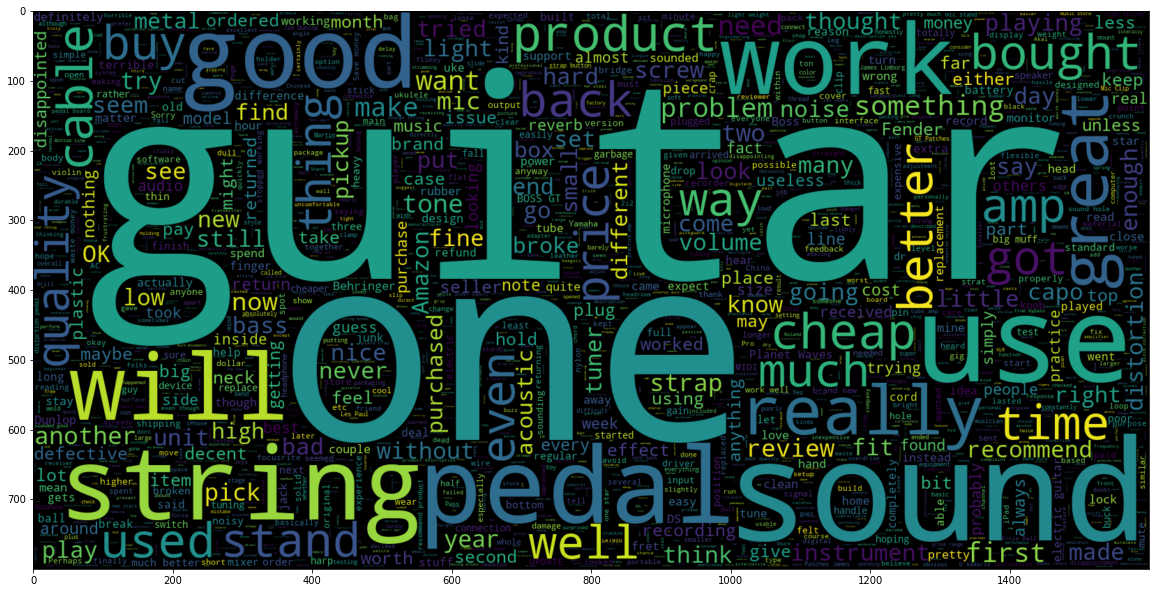

In [66]:
plt.figure(figsize = (20,20)) # Text Reviews with Poor Ratings
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800).generate(" ".join(bad))
plt.imshow(wc,interpolation = 'bilinear')

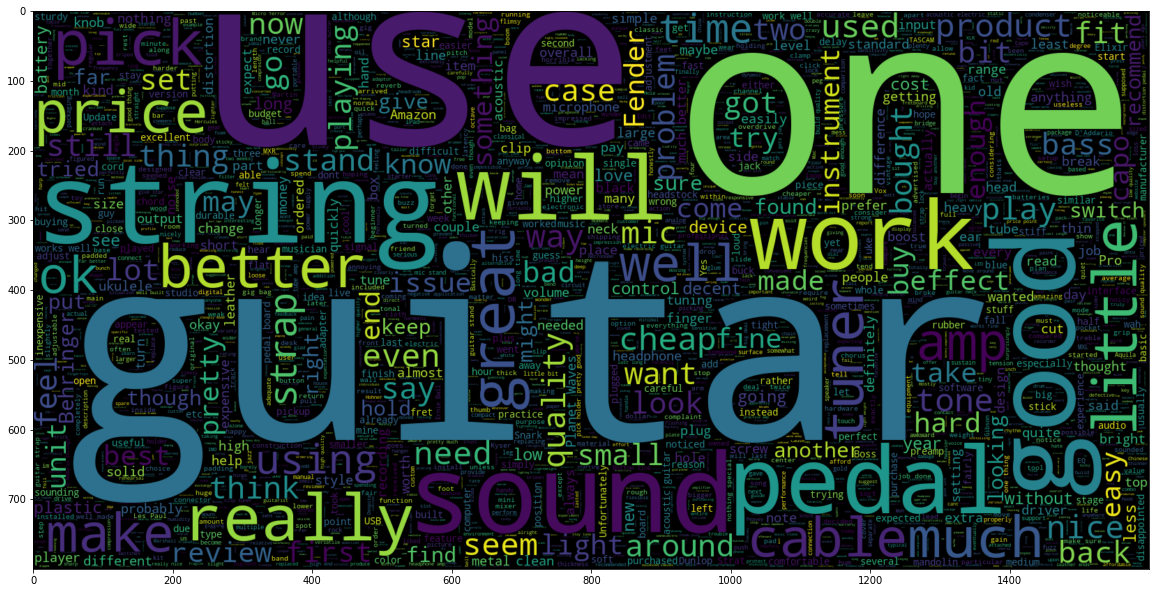

In [67]:
plt.figure(figsize = (20,20)) # # Text Reviews with Good Ratings
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800).generate(" ".join(neutral))
plt.imshow(wc,interpolation = 'bilinear')

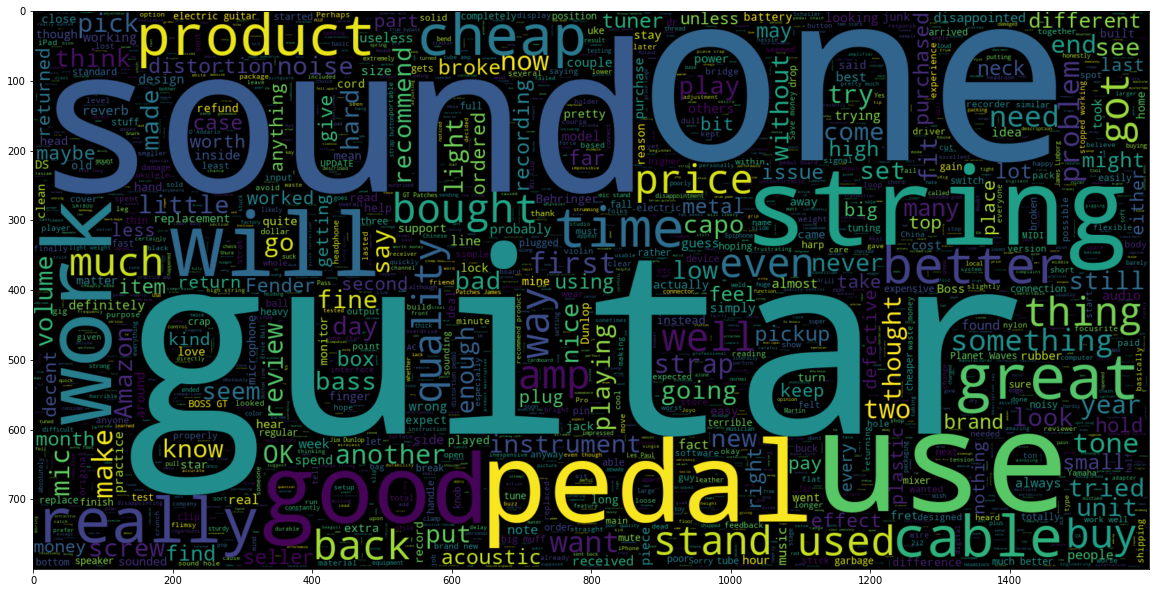

In [68]:
plt.figure(figsize = (20,20)) # # Text Reviews with Good Ratings
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800).generate(" ".join(bad))
plt.imshow(wc,interpolation = 'bilinear')

In [69]:
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(x_train)
#transformed test reviews
cv_test_reviews=cv.transform(x_test)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (8208, 651099)
BOW_cv_test: (2053, 651099)


In [70]:
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(x_train)
#transformed test reviews
tv_test_reviews=tv.transform(x_test)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (8208, 651099)
Tfidf_test: (2053, 651099)


In [71]:
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=0)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,y_train)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,y_train)
print(lr_tfidf)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [72]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)

In [73]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(y_test,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(y_test,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.8904042864101315
lr_tfidf_score : 0.8889430102289333
